In [39]:
%load_ext autoreload
%autoreload 2

import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
import numpy as np
from sklearn.metrics import classification_report

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader, CacheDataset, ThreadDataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirstd,
    AsDiscrete,
    Compose,
    LoadImage,
    LoadImaged,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensityd,
    EnsureTyped,
    Resized,
    CropForegroundd,
    Spacingd,
    SpatialPadd,
)
from monai.utils import set_determinism

print_config()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
MONAI version: 1.2.0
Numpy version: 1.25.0
Pytorch version: 2.0.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c33f1ba588ee00229a309000e888f9817b4f1934
MONAI __file__: /home/sven/miniconda3/envs/mlmi/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.1.0
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 10.0.0
Tensorboard version: 2.13.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.15.2+cu117
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.0.3
einops version: 0.6.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or 

In [40]:
import pandas as pd
import os
from enum import Enum

class Modality(Enum):
    MR_T1 = 1
    MR_T2 = 2
    MR_T2_STAR = 3
    MR_FLAIR = 4
    MR_TOF_MRA = 5

def create_oasis_3_dataset(csv_path: str, dataset_root: str, modality: Modality, transform):
    train_df = pd.read_csv(csv_path, sep=";")
    train_df.fillna('', inplace=True)

    column_name = ""
    if modality == Modality.MR_T1:
        column_name = "MR T1w"
    elif modality == Modality.MR_T2:
        column_name = "MR T2w"
    elif modality == Modality.MR_T2_STAR:
        column_name = "MR T2*"
    elif modality == Modality.MR_FLAIR:
        column_name = "MR FLAIR"
    elif modality == Modality.MR_TOF_MRA:
        column_name = "MR TOF-MRA"
    else:
        assert(False)

    train_data = []
    for index, row in train_df.iterrows():
        rel_path = row[column_name]
        if not rel_path:
            continue
        image_path = os.path.join(dataset_root, rel_path)
        train_data.append({"image": image_path, "label" : row["label"]})

    return CacheDataset(data=train_data, transform=transform, cache_rate=0.5, num_workers=5, copy_cache=False)

In [67]:
dataset_root = "/mnt/f/OASIS-3-MR-Sessions-2D/"
resolution = 256

foreground_crop_threshold = 0.1
train_table_path = "csv/oasis/oasis_3_multimodal_train.csv"
transform = Compose([
    LoadImaged("image", image_only=True),
    EnsureChannelFirstd("image", channel_dim="no_channel"),  
    EnsureTyped("image"),
    ScaleIntensityd("image"),
    CropForegroundd("image", source_key="image", select_fn=lambda x: x > foreground_crop_threshold, margin=5),
    Resized(keys=["image"], spatial_size=resolution, size_mode="longest"),
    SpatialPadd(keys=["image"], spatial_size=(resolution, resolution)),
    ]
)
train_ds = create_oasis_3_dataset(csv_path=train_table_path, dataset_root=dataset_root, modality=Modality.MR_T1, transform=transform)
# disable multi-workers because `ThreadDataLoader` works with multi-threads
train_loader = ThreadDataLoader(train_ds, num_workers=0, batch_size=4, shuffle=True)

Loading dataset: 100%|██████████| 1273/1273 [00:39<00:00, 32.43it/s]


torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])


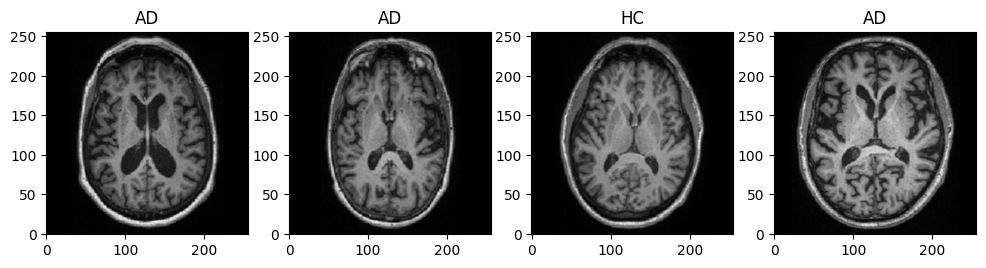

In [69]:
dataiter = iter(train_loader)
batch_sample = next(dataiter)
images = batch_sample["image"]
labels = batch_sample["label"]

classes = ["HC", "AD"]

plt.figure(figsize=(12, 6))
i = 0
for sample_data, sample_label in zip(images, labels):
    sample = sample_data[0]
    print(sample.shape)
    plt.subplot(1, 4, i+1)  # Create a subplot for each sample
    plt.imshow(sample.T, cmap='gray', origin='lower')
    plt.title(f"{classes[sample_label]}")  # Display the label as the title
    i += 1
plt.show()